# **MIT 6.5940 EfficientML.ai Fall 2023: Lab 0 PyTorch Tutorial**

In this tutorial, we will explore how to train a neural network with PyTorch.

### Setup

We will first install a few packages that will be used in this tutorial:

In [ ]:
# !pip install torchprofile 1>/dev/null

We will then import a few libraries:

In [1]:
import random
from collections import OrderedDict, defaultdict

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

/opt/homebrew/Caskroom/miniforge/base/envs/my_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To ensure the reproducibility, we will control the seed of random generators:

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

### Data

In this tutorial, we will use CIFAR-10 as our target dataset. This dataset contains images from 10 classes, where each image is of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

In [3]:
transforms = {
  "train": Compose([
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
  ]),
  "test": ToTensor(),
}

dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )

100%|██████████| 170498071/170498071 [00:06<00:00, 28235085.56it/s]


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10
Files already downloaded and verified


*ISS: Checking dataset*

In [10]:
dataset

{'train': Dataset CIFAR10
     Number of datapoints: 50000
     Root location: data/cifar10
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomCrop(size=(32, 32), padding=4)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 'test': Dataset CIFAR10
     Number of datapoints: 10000
     Root location: data/cifar10
     Split: Test
     StandardTransform
 Transform: ToTensor()}

In [9]:
len(dataset['train'])+len(dataset['test'])

60000

We can visualize a few images in the dataset and their corresponding class labels:

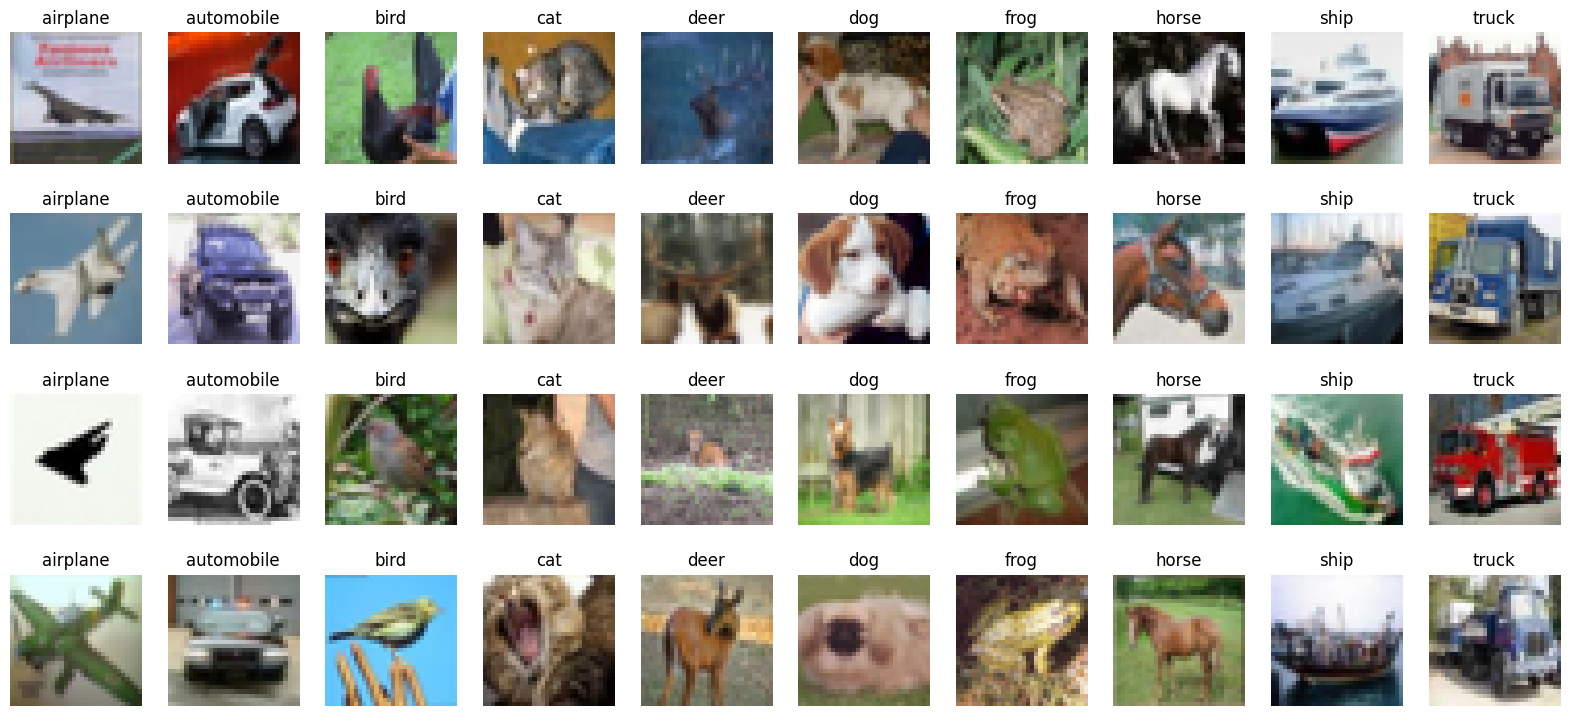

In [11]:
samples = [[] for _ in range(10)]
for image, label in dataset["test"]:
  if len(samples[label]) < 4:
    samples[label].append(image)

plt.figure(figsize=(20, 9))
for index in range(40):
  label = index % 10
  image = samples[label][index // 10]

  # Convert from CHW to HWC for visualization
  image = image.permute(1, 2, 0)

  # Convert from class index to class name
  label = dataset["test"].classes[label]

  # Visualize the image
  plt.subplot(4, 10, index + 1)
  plt.imshow(image)
  plt.title(label)
  plt.axis("off")
plt.show()

To train a neural network, we will need to feed data in batches. We create data loaders with batch size of 512:

In [12]:
dataflow = {}
for split in ['train', 'test']:
  dataflow[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

We can print the data type and shape from the training data loader:

In [13]:
for inputs, targets in dataflow["train"]:
  print("[inputs] dtype: {}, shape: {}".format(inputs.dtype, inputs.shape))
  print("[targets] dtype: {}, shape: {}".format(targets.dtype, targets.shape))
  break

[inputs] dtype: torch.float32, shape: torch.Size([512, 3, 32, 32])
[targets] dtype: torch.int64, shape: torch.Size([512])


In [14]:
def is_cuda():
    if torch.cuda.is_available():
        return True
    return False

### Model

In this tutorial, we will use a variant of [VGG-11](https://arxiv.org/abs/1409.1556) (with fewer downsamples and a smaller classifier) as our model.

In [15]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    # ISS, average along dim 2, 3, which was [x,x,2,2]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x

if is_cuda():
  model = VGG().cuda()
else:
  model = VGG()


*ISS, checking model*

In [16]:
model

VGG(
  (backbone): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (pool1): MaxPo

Its backbone is composed of eight `conv-bn-relu` blocks interleaved with four `maxpool`'s to downsample the feature map by 2^4 = 16 times:

In [17]:
print(model.backbone)

Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

After the feature map is pooled, its classifier predicts the final output with a linear layer:

In [18]:
print(model.classifier)

Linear(in_features=512, out_features=10, bias=True)


As this course focuses on efficiency, we will then inspect its model size and (theoretical) computation cost.


* The model size can be estimated by the number of trainable parameters:

In [19]:
num_params = 0
for param in model.parameters():
  if param.requires_grad:
    num_params += param.numel()
print("#Params:", num_params)

#Params: 9228362


* The computation cost can be estimated by the number of [multiply–accumulate operations (MACs)](https://en.wikipedia.org/wiki/Multiply–accumulate_operation) using [TorchProfile](https://github.com/zhijian-liu/torchprofile):

In [20]:
if is_cuda():
    num_macs = profile_macs(model, torch.zeros(1, 3, 32, 32).cuda())
else:
    num_macs = profile_macs(model, torch.zeros(1, 3, 32, 32))
print("#MACs:", num_macs)

#MACs: 606164480


This model has 9.2M parameters and requires 606M MACs for inference. We will work together in the next few labs to improve its efficiency.

### Optimization

As we are working on a classification problem, we will apply [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) as our loss function to optimize the model:

In [21]:
criterion = nn.CrossEntropyLoss()

Optimization will be carried out using [stochastic gradient descent (SGD)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) with [momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum):

In [22]:
optimizer = SGD(
  model.parameters(),
  lr=0.4,
  momentum=0.9,
  weight_decay=5e-4,
)

The learning rate will be modulated using the following scheduler (which is adapted from [this blog series](https://myrtle.ai/learn/how-to-train-your-resnet/)):

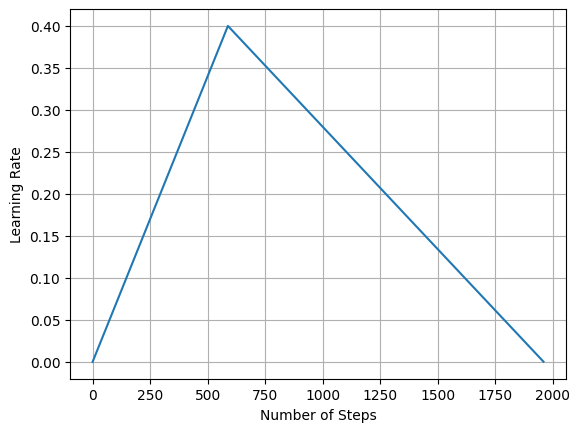

In [23]:
num_epochs = 20
steps_per_epoch = len(dataflow["train"])

# Define the piecewise linear scheduler
lr_lambda = lambda step: np.interp(
  [step / steps_per_epoch],
  [0, num_epochs * 0.3, num_epochs],
  [0, 1, 0]
)[0]

# Visualize the learning rate schedule
steps = np.arange(steps_per_epoch * num_epochs)
plt.plot(steps, [lr_lambda(step) * 0.4 for step in steps])
plt.xlabel("Number of Steps")
plt.ylabel("Learning Rate")
plt.grid("on")
plt.show()

scheduler = LambdaLR(optimizer, lr_lambda)

### Training

We first define the training function that optimizes the model for one epoch (*i.e.*, a pass over the training set):

In [25]:
def train(
  model: nn.Module,
  dataflow: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
) -> None:
  model.train()

  for inputs, targets in tqdm(dataflow, desc='train', leave=False):
    # Move the data from CPU to GPU
    if is_cuda():
      inputs = inputs.cuda()
      targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

We then define the evaluation function that calculates the metric (*i.e.*, accuracy in our case) on the test set:

In [26]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataflow: DataLoader
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataflow, desc="eval", leave=False):
    # Move the data from CPU to GPU
    if is_cuda():
      inputs = inputs.cuda()
      targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

With training and evaluation functions, we can finally start training the model! This will take around 10 minutes.

In [27]:
for epoch_num in tqdm(range(1, num_epochs + 1)):
  train(model, dataflow["train"], criterion, optimizer, scheduler)
  metric = evaluate(model, dataflow["test"])
  print(f"epoch {epoch_num}:", metric)

  5%|▌         | 1/20 [10:15<3:14:52, 615.37s/it]

epoch 1: 44.22999954223633


 10%|█         | 2/20 [20:20<3:02:48, 609.36s/it]

epoch 2: 46.2599983215332


 15%|█▌        | 3/20 [37:21<3:45:52, 797.23s/it]

epoch 3: 61.62999725341797


 20%|██        | 4/20 [47:47<3:14:33, 729.57s/it]

epoch 4: 59.810001373291016


 25%|██▌       | 5/20 [58:01<2:52:02, 688.17s/it]

epoch 5: 62.58000183105469


 30%|███       | 6/20 [1:08:09<2:34:12, 660.87s/it]

epoch 6: 56.160003662109375


 35%|███▌      | 7/20 [1:18:17<2:19:25, 643.46s/it]

epoch 7: 45.529998779296875


 40%|████      | 8/20 [1:28:18<2:05:59, 629.97s/it]

epoch 8: 69.7300033569336


 45%|████▌     | 9/20 [1:38:18<1:53:47, 620.68s/it]

epoch 9: 75.6500015258789


 50%|█████     | 10/20 [1:48:27<1:42:50, 617.03s/it]

epoch 10: 75.45999908447266


 55%|█████▌    | 11/20 [1:58:33<1:32:03, 613.70s/it]

epoch 11: 77.17000579833984


 60%|██████    | 12/20 [2:08:41<1:21:36, 612.01s/it]

epoch 12: 81.91999816894531


 65%|██████▌   | 13/20 [2:18:22<1:10:16, 602.36s/it]

epoch 13: 67.41999816894531


 70%|███████   | 14/20 [2:28:10<59:49, 598.25s/it]  

epoch 14: 86.13999938964844


 75%|███████▌  | 15/20 [2:37:59<49:36, 595.27s/it]

epoch 15: 86.79999542236328


 80%|████████  | 16/20 [2:48:05<39:54, 598.62s/it]

epoch 16: 88.02000427246094


 85%|████████▌ | 17/20 [2:58:10<30:01, 600.38s/it]

epoch 17: 88.58000183105469


 90%|█████████ | 18/20 [3:08:06<19:58, 599.07s/it]

epoch 18: 90.90999603271484


 95%|█████████▌| 19/20 [3:18:20<10:03, 603.63s/it]

epoch 19: 92.1500015258789


100%|██████████| 20/20 [3:28:33<00:00, 625.68s/it]

epoch 20: 92.79000091552734


If everything goes well, your trained model should be able to achieve >92.5\% of accuracy!

### Visualization

We can visualize the model's prediction to see how the model truly performs:

In [29]:
model = model.cpu()

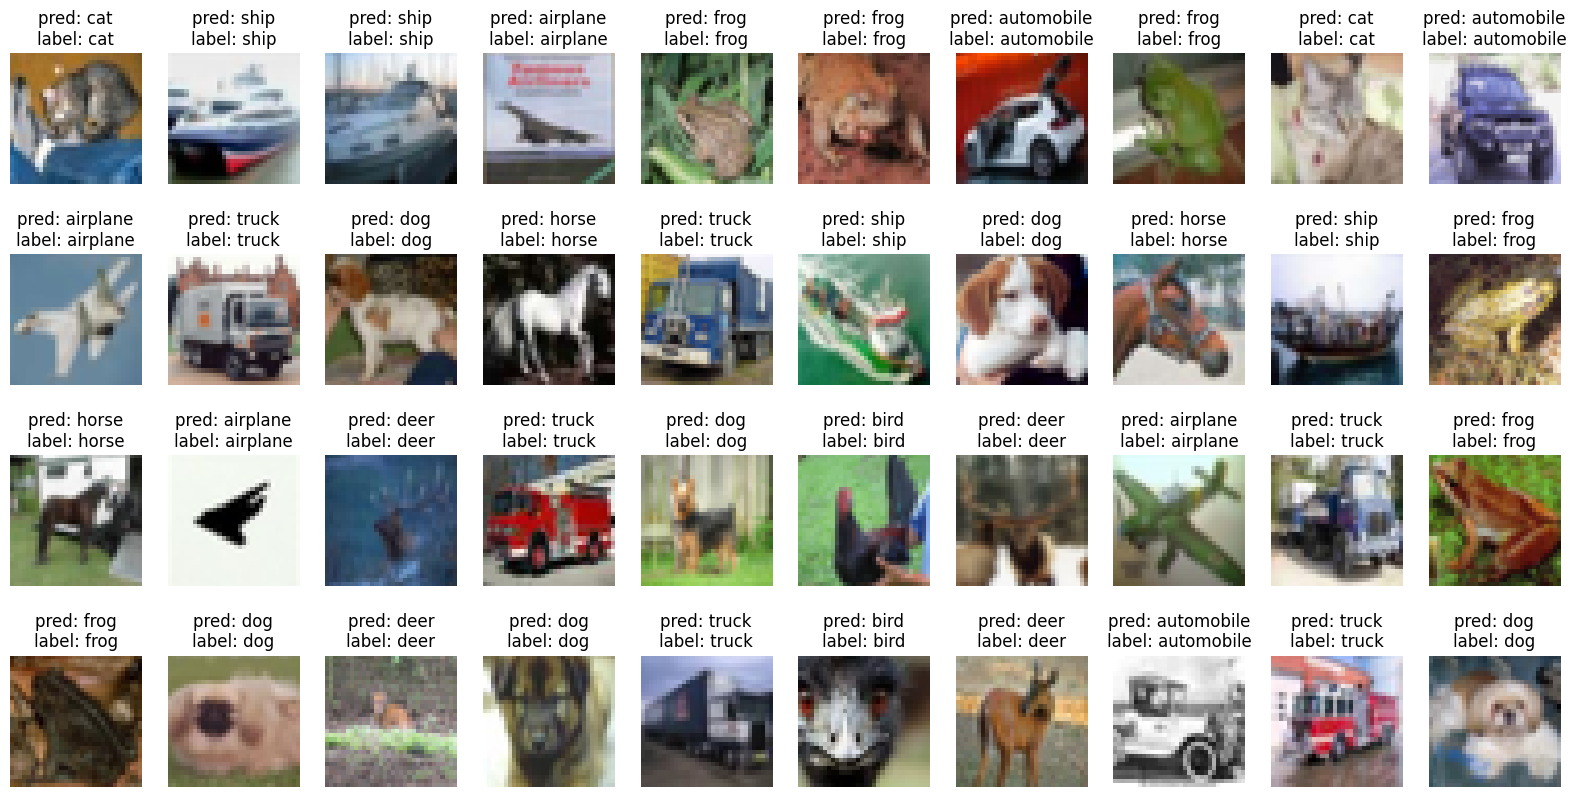

In [32]:
plt.figure(figsize=(20, 10))
for index in range(40):
  image, label = dataset["test"][index]

  # Model inference
  model.eval()
  with torch.inference_mode():
    if is_cuda():
      pred = model(image.unsqueeze(dim=0).cuda())
    else:
      pred = model(image.unsqueeze(dim=0))
    pred = pred.argmax(dim=1)

  # Convert from CHW to HWC for visualization
  image = image.permute(1, 2, 0)

  # Convert from class indices to class names
  pred = dataset["test"].classes[pred]
  label = dataset["test"].classes[label]

  # Visualize the image
  plt.subplot(4, 10, index + 1)
  plt.imshow(image)
  plt.title(f"pred: {pred}" + "\n" + f"label: {label}")
  plt.axis("off")
plt.show()